In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import pickle

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time

In [3]:
model = pickle.load(open('../models/rf_v1.p', 'rb'))

/home/suma/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/suma/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
data = pd.read_csv('../data/data_with_features_v1.csv')

In [5]:
#train_test_split

train_breath_ids, test_breath_ids = train_test_split(data['breath_id'].unique(), test_size=0.4, random_state=0)

train = data[data['breath_id'].isin(train_breath_ids)].copy()
test = data[data['breath_id'].isin(test_breath_ids)].copy()

assert(data.shape[0] == train.shape[0] + test.shape[0])

#creating features and target
x_train = train.drop(columns = ['id', 'breath_id', 'pressure'])
y_train = train['pressure']
x_test = test.drop(columns = ['id', 'breath_id', 'pressure'])
y_test = test['pressure']

In [6]:
#model performance

print(f'training score: {model.score(x_train,y_train)}')
print(f'model train mean absolute error: {mean_absolute_error(y_train, model.predict(x_train))}')

preds_model = model.predict(x_test)

print(f'model mean absolute error: {mean_absolute_error(y_test, preds_model)}')
print(f'model rmse: {mean_squared_error(y_test, preds_model, squared=False)}')

training score: 0.9934102626332331
model train mean absolute error: 0.3658288968567603
model mean absolute error: 0.487670315565796
model rmse: 0.9174024416901989


In [7]:
#adding predicts to the test DataFrame

test['prediction'] = preds_model
test['mae'] = np.abs(test['pressure']-test['prediction'])


In [8]:
#performance much better in the expiration phase than in the inspiration phase

test[['breath_id','pressure','prediction','mae','u_out']].groupby('u_out').mean()
test[['breath_id','pressure','prediction','mae','u_out']].groupby(['breath_id','u_out']).mean()

,breath_id,pressure,prediction,mae
u_out,,,,
0,62815.559819,17.605792,17.606317,0.843971
1,62800.680270,7.325495,7.323020,0.269703


pressure  prediction       mae
breath_id u_out                                 
1         0      16.200028   17.112715  0.935178
          1       7.625978    7.516004  0.277736
2         0      13.832543   12.939161  0.905826
          1       6.776232    6.925650  0.482566
4         0      23.531663   22.432111  1.258038
...                    ...         ...       ...
125742    1       7.585203    7.621649  0.507385
125745    0      22.787112   21.787244  1.030574
          1       7.774388    7.522354  0.324458
125749    0      22.756875   21.481404  1.366543
          1       6.790789    6.764059  0.476192

[45226 rows x 3 columns]

In [9]:
#mae by breath

df = test[['breath_id','pressure','prediction','mae','u_out']].groupby(['breath_id']).mean().reset_index().copy()
df.head()


,breath_id,pressure,prediction,mae,u_out
0,1,10.841247,11.114770,0.524277,0.6250
1,2,9.334145,9.105548,0.635998,0.6375
2,4,13.914329,13.453856,0.724477,0.6000
3,10,13.086522,12.292098,0.833430,0.6125
4,20,6.852479,7.016002,0.226109,0.6375


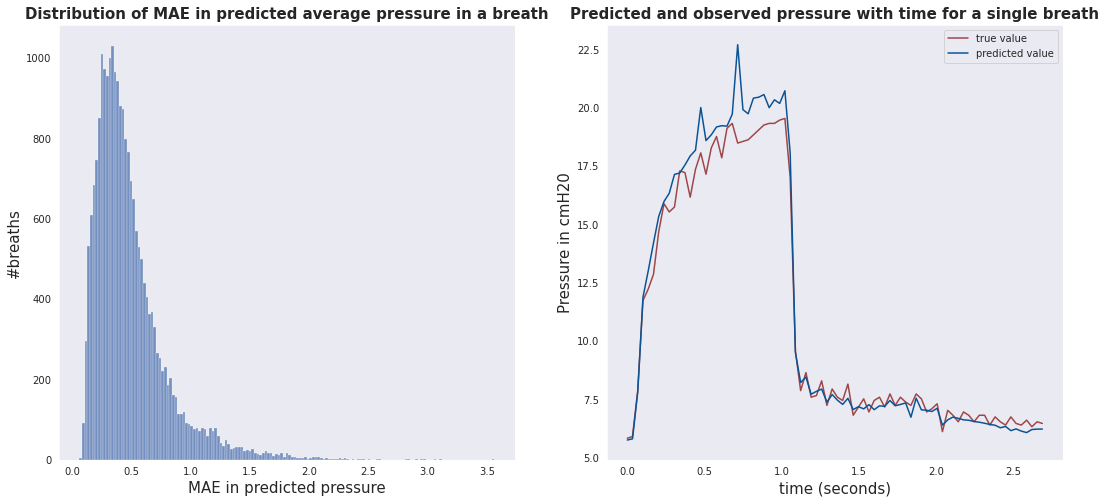

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,8));
breath_id = 1

#distribution of mae by breath

df = test[['breath_id','pressure','prediction','mae','u_out']].groupby(['breath_id']).mean().reset_index().copy()
df.head()

sns.histplot(df['mae'],ax=ax[0] );
ax[0].set_title('Distribution of MAE in predicted average pressure in a breath',fontsize=15, fontweight='bold');
ax[0].set_xlabel('MAE in predicted pressure')
ax[0].set_ylabel('#breaths')

#predicted and true values of pressure for a few sample breaths
df = test[test['breath_id'] == breath_id]
sns.lineplot(data = df, y = 'pressure', x = 'time_step', 
             ax = ax[1], alpha = 0.7, color = 'maroon', label = 'true value');
sns.lineplot(data = df, y = 'prediction', x = 'time_step', 
             ax = ax[1], alpha = 1, color = myblue, label = 'predicted value');

ax[1].set_title('Predicted and observed pressure with time for a single breath', fontsize=15, fontweight='bold');
plt.xlabel('time (seconds)');
plt.ylabel('Pressure in cmH20');


In [11]:
# mean mae across breaths at a given time step
test['time_step#'] = test.groupby(['breath_id'])[['time_step']].rank()
df = test.groupby('time_step#')[['mae']].mean().reset_index()
df.head()


,time_step#,mae
0,1.0,0.426605
1,2.0,0.258703
2,3.0,0.293821
3,4.0,0.414331
4,5.0,0.529614


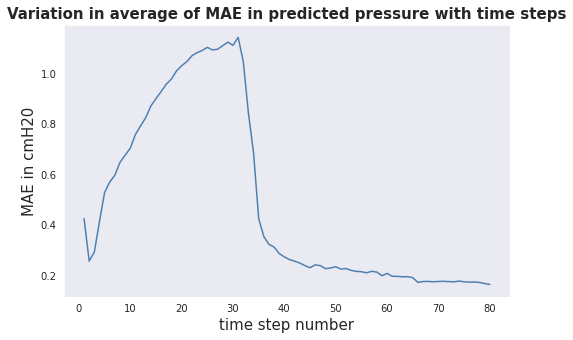

In [12]:
fig, ax = plt.subplots(figsize=(8,5));
sns.lineplot(data = df, y = 'mae', x = 'time_step#', ax = ax, alpha = 0.7, color = myblue);
plt.xlabel('time step number');
plt.ylabel('MAE in cmH20');
plt.title('Variation in average of MAE in predicted pressure with time steps',fontsize=15, fontweight='bold'); 